In [3]:
import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import matplotlib.image as image
import argparse

import boto3
import sagemaker

#from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import PIL

In [3]:
%%time # Downloading PASCAL Dataset to the notebook in Sagemaker

print('Downloading the dataset...')
!wget -P /tmp https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz

print('Extracting VOC2012...')
!tar -xf /tmp/pascal-voc.tgz --wildcards pascal-voc/VOC2012*

print('Deleting /tmp files...')
!rm /tmp/pascal-voc.tgz

print('Download completed!')

--2021-05-14 10:32:08--  https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
Resolving fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)... 52.217.203.129
Connecting to fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)|52.217.203.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4639722845 (4.3G) [application/x-tar]
Saving to: ‘/tmp/pascal-voc.tgz’

pascal-voc.tgz      100%[===================>]   4.32G  4.49MB/s    in 13m 21s 

2021-05-14 10:45:29 (5.53 MB/s) - ‘/tmp/pascal-voc.tgz’ saved [4639722845/4639722845]

Extracting VOC2012...
Deleting /tmp files...
Download completed!
CPU times: user 16.7 s, sys: 4.5 s, total: 21.2 s
Wall time: 14min 33s


In [10]:
print('{} images  in pascal-voc/VOC2012/JPEGImages'.format(len(os.listdir('pascal-voc/VOC2012/JPEGImages'))))
print('{}segmentation images  in pascal-voc/VOC2012/SegmentationClass'.format(len(os.listdir('pascal-voc/VOC2012/SegmentationClass'))))

33260 images  in pascal-voc/VOC2012/JPEGImages
2913segmentation images  in pascal-voc/VOC2012/SegmentationClass


There are 2913 Segmentation samples in the dataset. But in JPEGImages folder there are 33260 images. So, for this notebook, only 2913 images will be used as Semantic Segmentation sample numbers.

In [17]:
images_names = 'pascal-voc/VOC2012/ImageSets/Segmentation/trainval.txt'


os.makedirs('data/train_val_img', exist_ok=True)
os.makedirs('data/train_val_seg', exist_ok=True)


with open(images_names) as f:
    train_list = f.read().splitlines() 
    
for i in train_list:
    shutil.copy2('pascal-voc/VOC2012/JPEGImages/'+i+'.jpg', 'data/train_val_img/')
    shutil.copy2('pascal-voc/VOC2012/SegmentationClass/'+i+'.png','data/train_val_seg/')   

    

In [27]:
folders=['train','train_annotation','validation','validation_annotation']

path='data/'

for folder in folders:
    os.makedirs(path+folder)
    


In [41]:
all_images='data/train_val_img'

all_annotations='data/train_val_seg'

for image in os.listdir(all_images):
    
    target_set='train' if random.randint(0,99)< 80 else 'validation'
    
    image_file_path=os.path.join(all_images,image)
    print(image_file_path)
    image_target_path=os.path.join(os.path.join('data',target_set),image)
    print(image_target_path)
    annots=image.split('.')[0] + '.png'
    
    map_file_path=os.path.join(all_annotations,annots)
    map_target_path=os.path.join(os.path.join('data',target_set) + '_annotation',annots)
    
    shutil.copy(image_file_path,image_target_path)
    shutil.copy(map_file_path,map_target_path)

data/train_val_img/2011_000521.jpg
data/train/2011_000521.jpg
data/train_val_img/2007_002488.jpg
data/validation/2007_002488.jpg
data/train_val_img/2007_000645.jpg
data/train/2007_000645.jpg
data/train_val_img/2008_002258.jpg
data/train/2008_002258.jpg
data/train_val_img/2008_001829.jpg
data/train/2008_001829.jpg
data/train_val_img/2010_003971.jpg
data/validation/2010_003971.jpg
data/train_val_img/2010_003274.jpg
data/train/2010_003274.jpg
data/train_val_img/2007_008142.jpg
data/train/2007_008142.jpg
data/train_val_img/2009_001782.jpg
data/train/2009_001782.jpg
data/train_val_img/2008_000273.jpg
data/train/2008_000273.jpg
data/train_val_img/2011_002385.jpg
data/validation/2011_002385.jpg
data/train_val_img/2007_006117.jpg
data/train/2007_006117.jpg
data/train_val_img/2010_003269.jpg
data/validation/2010_003269.jpg
data/train_val_img/2008_002471.jpg
data/train/2008_002471.jpg
data/train_val_img/2007_000363.jpg
data/train/2007_000363.jpg
data/train_val_img/2007_000032.jpg
data/train/2007

In [48]:
print(len(os.listdir('data/train')))
print(len(os.listdir('data/validation')))

2332
581


Train and validation portions were prefered as 0.8 to 0.2 to be able to train with more examples.

In [5]:
sess=sagemaker.Session()
role=sagemaker.get_execution_role()

In [50]:
sess=sagemaker.Session()
role=sagemaker.get_execution_role()
bucket_name='pascal-segmentation'
print('uploading data to s3...')
s3_data_path=sess.upload_data(path='data/train',bucket=bucket_name,key_prefix='train')
print('train file uploaded to ',s3_data_path)
s3_data_path=sess.upload_data(path='data/train_annotation',bucket=bucket_name,key_prefix='train_annotation')
print('train annotation file uploaded to ',s3_data_path)
s3_data_path=sess.upload_data(path='data/validation',bucket=bucket_name,key_prefix='validation')
print('validation file uploaded to ',s3_data_path)
s3_data_path=sess.upload_data(path='data/validation_annotation',bucket=bucket_name,key_prefix='validation_annotation')
print('validation annotation file uploaded to ',s3_data_path)

uploading data to s3...
train file uploaded to  s3://pascal-segmentation/train
train annotation file uploaded to  s3://pascal-segmentation/train_annotation
validation file uploaded to  s3://pascal-segmentation/validation
validation annotation file uploaded to  s3://pascal-segmentation/validation_annotation


After preparing the data, it was uploaded to bucket in S3 which named "pascal-segmenatation"


In [3]:
training_image=get_image_uri(boto3.Session().region_name,'semantic-segmentation',repo_version='latest')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


To train the model, Semantic-Segmenation algorithm which is one of the Sagemaker built-in algorithms was picked. Then, a model was builded. In the model created, as ResNet-101 was chosen as backbone (for encoder stage) for deeper learning. This might also cause overfitting sometimes. Fully Connected Network was selected for decoder part. 

In [7]:
model=sagemaker.estimator.Estimator(training_image,
                                   role=role,
                                   train_instance_count=1,
                                   train_instance_type='ml.p3.2xlarge',
                                   train_volume_size=100,
                                   train_max_run=36000,
                                   input_mod='file',
                                   output_path='s3://pascal-segmentation/output',
                                    base_job_name='ss-updated',
                                   sagemaker_session=sess)

# Hyperparameters
model.set_hyperparameters(
    backbone='resnet-101', # This is the encoder. Other option is resnet-101
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True',
    crop_size=240, # Size of image random crop.                             
    num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=20, 
    learning_rate=0.0001,                             
    optimizer='adam', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, 
    validation_mini_batch_size=16,
    early_stopping=True, 
    early_stopping_patience=4, 
    early_stopping_min_epochs=20,                            
    num_training_samples=2332)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [8]:
s3_train_path='s3://pascal-segmentation/train'
s3_validation_path='s3://pascal-segmentation/validation'
s3_train_annotation_path='s3://pascal-segmentation/train_annotation'
s3_validation_annotation_path='s3://pascal-segmentation/validation_annotation'

In [9]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [10]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In this part below, data channels were given to the model and trainin process was started.

In [11]:
# Model Training
model.fit(inputs=data_channels, logs=True)

2021-05-16 21:50:25 Starting - Starting the training job...
2021-05-16 21:50:27 Starting - Launching requested ML instancesProfilerReport-1621201825: InProgress
......
2021-05-16 21:51:39 Starting - Preparing the instances for training......
2021-05-16 21:52:48 Downloading - Downloading input data......
2021-05-16 21:53:55 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[05/16/2021 21:53:59 INFO 139953671223104] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.9', 'mini_batch_size': '

When the train finished, the model reached  0.7012568406420143 validation mIOU (Intersection over union) and  0.91905023621 validation pixel_accuracy which look decent result. To get better outcome, some hyperparameters tuning can be done and training could be repeated few more times (e.g. increasing number of epochs or tuning optimizer etc.) 

In [12]:
#Deploying the model 
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

---------------!
Model deployed!


The model was deployed. This stage also creates specific Endpoint and its Enpoint Configuration.

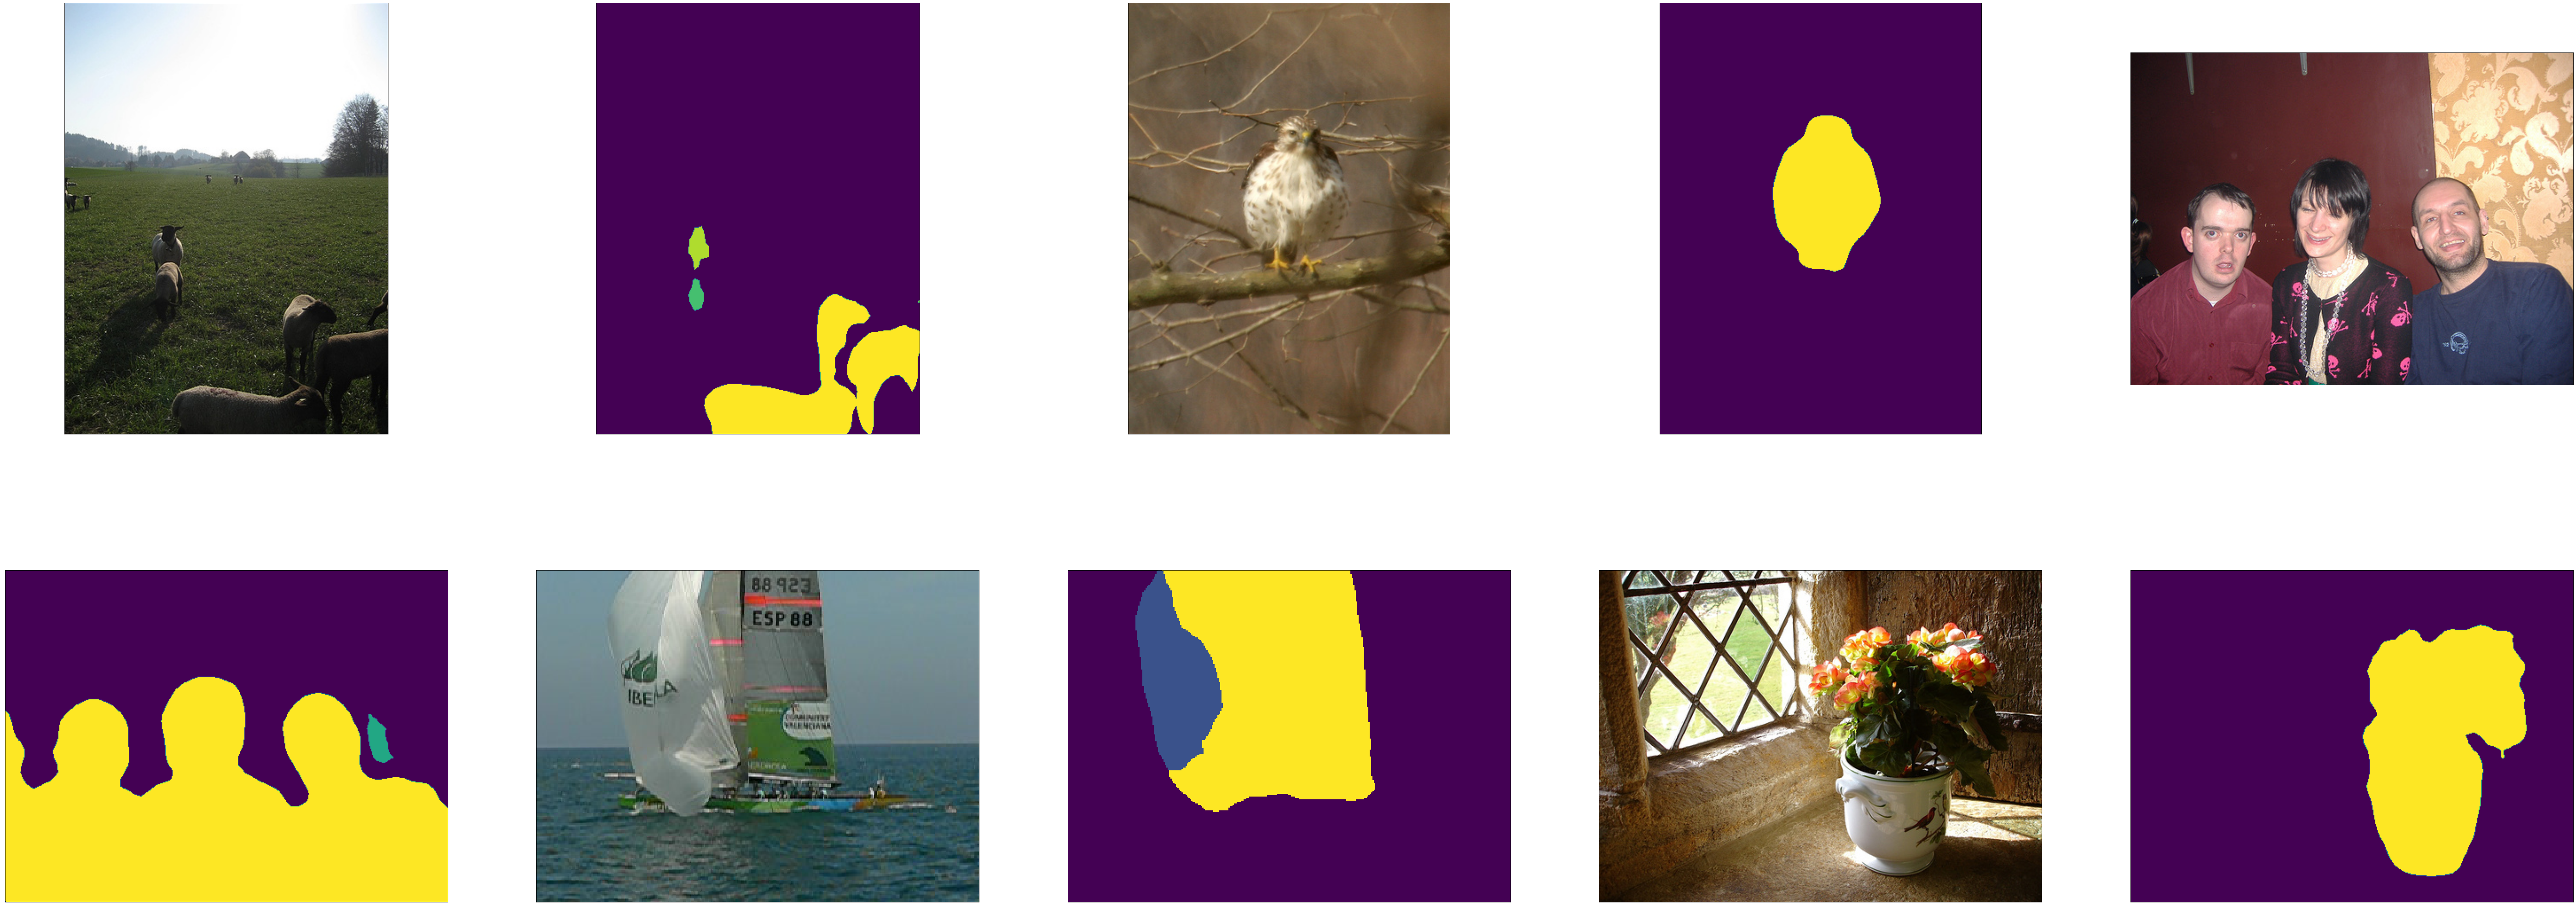

In [17]:

class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""
    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


deployed_model.deserializer = ImageDeserializer(accept="image/png")
deployed_model.serializer = sagemaker.serializers.IdentitySerializer('image/jpeg')


image_dir = 'data/validation'


images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']


'''
index = 5

image_path = os.path.join(image_dir, images[index])


with open(image_path, 'rb') as f:
    b = bytearray(f.read())

prediction = deployed_model.predict(b)

plt.imshow(prediction)

plt.show()

'''



plt.figure(figsize=(100,100))

for i in range(0,5):
    index=random.randint(0,100)
    image_path = os.path.join(image_dir, images[index])
   
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
       

    prediction = deployed_model.predict(b)
    plt.subplot(5,5, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(image_path))
    plt.subplot(5, 5, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(prediction)
plt.show()



Model works well on the validation set. Additionally, after this stage, a Lambda function and Api Gateway can be created to be used via Rest Api URL from outside of AWS.


In [ ]:
deployed_model.delete_endpoint()